<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/9_embeddings_transformers_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte1: RNN y embeddings

###Preparamos el ambiente



Descargamos los embedding clínicos calculados por PLN@CMM

Link: https://pln.cmm.uchile.cl/grav/en

In [ ]:
# Descargamos el embedding clinico
!gdown https://drive.google.com/uc?id=1MW0QCwXmBl3geQd-Mh_iFMAFOtvSExf5

# Descargamos el vocabulario utilizado para el dataset
!gdown https://drive.google.com/uc?id=12CXusMRCEvFA6i5Ta7KIqGy55AQdOAoH

# Descargamos dataset
!gdown https://drive.google.com/uc?id=1FDr4gfCVKAQJQ6V0EnA9pj7BM5vB-Sch #conjunto train
!gdown https://drive.google.com/uc?id=1IRENWFck-8EkUd1gFXhNvhiloyOfeGkG #conjunto test

Downloading...
From (original): https://drive.google.com/uc?id=1MW0QCwXmBl3geQd-Mh_iFMAFOtvSExf5
From (redirected): https://drive.google.com/uc?id=1MW0QCwXmBl3geQd-Mh_iFMAFOtvSExf5&confirm=t&uuid=02649c10-7575-46e7-9f15-30abf9b7e2fe
To: /content/cwlce.vec
100% 163M/163M [00:01<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=12CXusMRCEvFA6i5Ta7KIqGy55AQdOAoH
To: /content/cwlce_vocab.txt
100% 574k/574k [00:00<00:00, 64.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FDr4gfCVKAQJQ6V0EnA9pj7BM5vB-Sch
To: /content/spanish_diagnostics_train.csv
100% 4.75M/4.75M [00:00<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IRENWFck-8EkUd1gFXhNvhiloyOfeGkG
To: /content/spanish_diagnostics_test.csv
100% 1.99M/1.99M [00:00<00:00, 186MB/s]


In [ ]:
import tensorflow as tf # Biblioteca de deep learning
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt # Biblioteca de visualización
import numpy as np # Biblioteca de manejo de datos vectoriales
import pandas as pd

2.0.2


### Dataset

In [ ]:
# Cargamos el dataset
train_df = pd.read_csv("/content/spanish_diagnostics_train.csv")
test_df = pd.read_csv("/content/spanish_diagnostics_test.csv")

spanish_diagnostics = DatasetDict({"train": Dataset.from_pandas(train_df),"test": Dataset.from_pandas(test_df)})

In [ ]:
# Diccionario creado por la funcion dataset
spanish_diagnostics

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
})

In [ ]:
# Ejemplo de las primeras 10 oraciones y etiquetas
display(spanish_diagnostics['train']['text'][0:10])
print()
display(spanish_diagnostics['train']['label'][0:10])

['- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'OBTRUCCION FOSA NASAL DERECHA',
 'Perturbación de la actividad y de la atención Trastorno defícit atencional',
 'M7 PROLAPSO VAGINAL PARED ANTERIOR G11 G 111 ALGIA PELVICA HTA CRONICA',
 'PIEZA 3 CARIES DENTINARIA PROFUNDA PROXIMA A CAMARA PULPAR, EVALUAR POR ESPECIALIDAD',
 'pieza n 3.4 tratada endodonticamente, restaurada con ionomero y resina compuesta. Necesita protesis fija por gran pNrdida coronaria',
 'PZ. 12 TREPANADA',
 'CARCINOMA TORIODEO',
 'DISPEPSIA Y METEORISMO',
 'ASA 1 DENTICION TEMPORAL MORDIDA CRUZADA']

[1, 0, 0, 0, 1, 1, 1, 0, 0, 1]

Problema binario de clasificación con texto asociado a encontrar si el texto analizado es o no, del área de odontología.

*   0: Problema de otra área
*   1: Problema de odontología



## Preprocesamiento

In [ ]:
import re # Libreria para trabajar con texto

# Funcion para lematizar -> Quitar variaciones del texto incesarias
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

# Funcion para convertir el texto a vectores numericos, en donde cada palabra se mapea a un numero
def text_to_sequence(text,vocab):
  """Esta función recibe una lista de strings y devuelve una lista de listas de índices del vocabulario"""
  sequences = []
  tokens = tf.keras.preprocessing.text.text_to_word_sequence(text)
  sequence = [vocab.index(word) for word in tokens if word in vocab]
  sequences.append(sequence)
  return sequences

# Funcion para convertir los vectores numericos a vectores del mismo tamaño
def encode_text(text,vocab,maxlen=20):
  """Esta función recibe string y devuelve una lista de índices del vocabulario con padding"""
  sequences = text_to_sequence(text,vocab)
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen, padding='post')
  return padded_sequences[0]

Normalizamos el corpus.

In [ ]:
# Se normaliza con la funcion previa el texto
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text" : normalize(x["text"])
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
print('#'*100)
print('Dataset')
print('#'*100)
print()
print(spanish_diagnostics_normalized)
print()

print('#'*100)
print('Texto normalizado')
print('#'*100)
print()
display(spanish_diagnostics_normalized['train']['normalized_text'][0:10])
print()

print('#'*100)
print('Texto sin normalizar')
print('#'*100)
print()
display(spanish_diagnostics_normalized['train']['text'][0:10])

####################################################################################################
Dataset
####################################################################################################

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'normalized_text'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['text', 'label', 'normalized_text'],
        num_rows: 30000
    })
})

####################################################################################################
Texto normalizado
####################################################################################################



['  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'obtruccion fosa nasal derecha',
 'perturbacion de la actividad y de la atencion trastorno deficit atencional',
 'm  prolapso vaginal pared anterior g   g     algia pelvica hta cronica',
 'pieza   caries dentinaria profunda proxima a camara pulpar  evaluar por especialidad',
 'pieza n     tratada endodonticamente  restaurada con ionomero y resina compuesta  necesita protesis fija por gran pnrdida coronaria',
 'pz     trepanada',
 'carcinoma toriodeo',
 'dispepsia y meteorismo',
 'asa   denticion temporal mordida cruzada']


####################################################################################################
Texto sin normalizar
####################################################################################################



['- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'OBTRUCCION FOSA NASAL DERECHA',
 'Perturbación de la actividad y de la atención Trastorno defícit atencional',
 'M7 PROLAPSO VAGINAL PARED ANTERIOR G11 G 111 ALGIA PELVICA HTA CRONICA',
 'PIEZA 3 CARIES DENTINARIA PROFUNDA PROXIMA A CAMARA PULPAR, EVALUAR POR ESPECIALIDAD',
 'pieza n 3.4 tratada endodonticamente, restaurada con ionomero y resina compuesta. Necesita protesis fija por gran pNrdida coronaria',
 'PZ. 12 TREPANADA',
 'CARCINOMA TORIODEO',
 'DISPEPSIA Y METEORISMO',
 'ASA 1 DENTICION TEMPORAL MORDIDA CRUZADA']

In [ ]:
# Cargamos el vocabulario del archivo cwlce_vocab.txt
vocab = []
with open("cwlce_vocab.txt", 'r', encoding="utf-8") as f:
  for line in f:
    vocab.append(line.strip())

Con nuestro texto normalizado, proseguimos a convertir nuestras oraciones en vectores tokenizados.

In [ ]:
spanish_diagnostics_normalized_encoded = spanish_diagnostics_normalized.map(
    lambda x: {
        "encoded_text" : encode_text(x["normalized_text"],vocab)})

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [ ]:
spanish_diagnostics_normalized_encoded['train'][0]

{'text': '- ANOMALÍAS DENTOFACIALES (INCLUSO LA MALOCLUSIÓN)\n\n\n DISCREPANCIA DENTOMAXILAR',
 'label': 1,
 'normalized_text': '  anomalias dentofaciales  incluso la maloclusion     discrepancia dentomaxilar',
 'encoded_text': [76,
  123,
  131,
  3,
  83,
  2552,
  737,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

### Ejemplo para una sola oracion en orden

In [ ]:
oracion_1 = spanish_diagnostics['train'][1]['text']
print(f'Esta es la oracion 1: {oracion_1}')
oracion_1_normalizada = normalize(oracion_1)
print(f'Esta es la oracion 1 normalizada: {oracion_1_normalizada}')
oracion_1_tokenizada = text_to_sequence(oracion_1_normalizada,vocab)
print(f'Esta es la oracion 1 tokenizada: {oracion_1_tokenizada}')
oracion_1_codificada = encode_text(oracion_1_normalizada,vocab)
print(f'Esta es la oracion 1 tokenizada con pad: {oracion_1_codificada}')

Esta es la oracion 1: OBTRUCCION FOSA NASAL DERECHA
Esta es la oracion 1 normalizada: obtruccion fosa nasal derecha
Esta es la oracion 1 tokenizada: [[3869, 1885, 208, 53]]
Esta es la oracion 1 tokenizada con pad: [3869 1885  208   53    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


## Modelamiento

En esta seccion observaremos el comportamiento de este modelo para distintas capas de embedding, observando como varia el performance.

In [ ]:
# Dado que utilizaremos esta arquitectura multiples veces crearemos una funcion que sigue esta logica

def make_model(embedding,trainable_embeddings,vocab):
  """Con esta función instanciamos la arquitectura de red neuronal recurrente."""
  model = tf.keras.Sequential()

  if embedding.any() == "random":
    # Caso capa de embedding desde 0
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=300,
        trainable=trainable_embeddings,
        mask_zero=True)

  else:
    # Caso capa de embedding entrenada
    embedding_layer = tf.keras.layers.Embedding(
        input_dim=len(vocab),
        output_dim=embedding.shape[1],
        trainable=trainable_embeddings,
        weights=[embedding], # Inicializamos la capa de embedding con los embedding preentrenados.
        mask_zero=True)


  model.add(embedding_layer)                                       # Agregamos la capa de embedding a la arquitectura
  model.add(tf.keras.layers.SimpleRNN(128,recurrent_dropout=0.2))  # Simple RNN
  model.add(tf.keras.layers.Dropout(0.3))                          # Esta capa al azar cambia por 0 el 30 % de los pesos con el fin de disminuir el sobreajuste.
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))        # Esta es la capa de clasificación binaria.

  # Compilador del modelo
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

![texto del vínculo](https://miro.medium.com/v2/resize:fit:1194/1*B0q2ZLsUUw31eEImeVf3PQ.png)

In [ ]:
# Conjunto TRAIN [convertimos numpy array]
train_set_features = np.asarray(spanish_diagnostics_normalized_encoded['train']['encoded_text'][:7000])
train_set_labels = np.asarray(spanish_diagnostics_normalized_encoded['train']['label'][:7000])
# Conjunto TEST [convertimos numpy array]
val_set_features = np.asarray(spanish_diagnostics_normalized_encoded['test']['encoded_text'][:3000])
val_set_labels = np.asarray(spanish_diagnostics_normalized_encoded['test']['label'][:3000])
train_set_features.shape, val_set_features.shape

((7000, 20), (3000, 20))

### Caso 1: Modelo con embedding sin entrenar, ajustado/entrenado durante el entrenamiento

In [ ]:
# Inicializamos modelo
model_random_trainable = make_model(
    embedding = "random", # No usamos embeddings preentrenados.
    trainable_embeddings = True, # Entrenamos capa de embedding.
    vocab = vocab)

# Entrenamos
model_random_trainable_hist = model_random_trainable.fit(
    train_set_features,
    train_set_labels,
    epochs=10,
    validation_data=(val_set_features,val_set_labels,))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7542 - loss: 0.5068 - val_accuracy: 0.9360 - val_loss: 0.1918
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9583 - loss: 0.1433 - val_accuracy: 0.9367 - val_loss: 0.1762
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9724 - loss: 0.0991 - val_accuracy: 0.9363 - val_loss: 0.1901
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9845 - loss: 0.0566 - val_accuracy: 0.9377 - val_loss: 0.1992
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9884 - loss: 0.0383 - val_accuracy: 0.9327 - val_loss: 0.2350
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9909 - loss: 0.0315 - val_accuracy: 0.9313 - val_loss: 0.2484
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9903 - loss: 0.0309 - val_accuracy: 0.9337 - val_loss: 0.2387
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9942 - loss: 0.0222 - val_accuracy:

### Caso 2: Modelo con embedding sin entrenar, sin ser ajustado/entrenado durante el entrenamiento (Freeze).

In [ ]:
# Inicializamos modelo
model_random_frozen = make_model(
    embedding = "random", # No usamos embeddings preentrenados.
    trainable_embeddings = False, # Congelamos capa de embedding.
    vocab = vocab)

# Entrenamos
model_random_frozen_hist = model_random_frozen.fit(
    train_set_features,
    train_set_labels,
    epochs=10,
    validation_data=(val_set_features,val_set_labels,))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6373 - loss: 0.6509 - val_accuracy: 0.7980 - val_loss: 0.5235
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7831 - loss: 0.5340 - val_accuracy: 0.7917 - val_loss: 0.4835
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7773 - loss: 0.5136 - val_accuracy: 0.6957 - val_loss: 0.5469
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7337 - loss: 0.5458 - val_accuracy: 0.7830 - val_loss: 0.4798
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7902 - loss: 0.4823 - val_accuracy: 0.8137 - val_loss: 0.4466
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8168 - loss: 0.4543 - val_accuracy: 0.8163 - val_loss: 0.4306
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8120 - loss: 0.4398 - val_accuracy: 0.8097 - val_loss: 0.4634
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8115 - loss: 0.4701 - val_accuracy: 0

### Comparacion caso 1 y 2

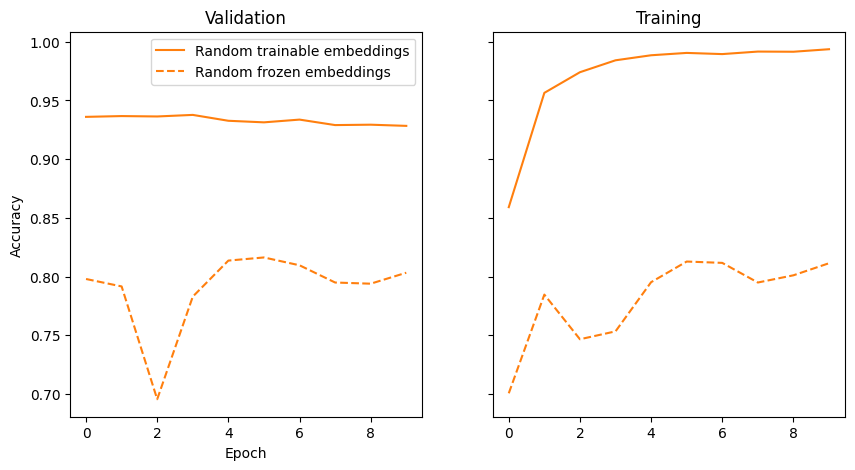

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

axs[0].plot(
    model_random_trainable_hist.history["val_accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[0].plot(
    model_random_frozen_hist.history["val_accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)

axs[1].plot(
    model_random_trainable_hist.history["accuracy"],
    c="tab:orange",
    label="Random trainable embeddings"
)
axs[1].plot(
    model_random_frozen_hist.history["accuracy"],
    c="tab:orange",
    linestyle="--",
    label="Random frozen embeddings"
)
axs[0].legend()
axs[0].set_title("Validation")
axs[1].set_title("Training")
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("Epoch")
plt.show()

In [ ]:
# Cargamos embeddings clinicos
def load_word2vec_vec(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        # Leer primera línea: vocab_size y dimension
        first_line = f.readline()
        vocab_size, vector_dim = map(int, first_line.strip().split())

        # Crear dict para palabra -> vector
        word_vectors = {}
        # Crear matriz para todos los vectores (opcional)
        vectors = np.zeros((vocab_size, vector_dim), dtype=np.float32)
        words = []

        for i, line in enumerate(f):
            parts = line.rstrip().split(' ')
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            word_vectors[word] = vector
            vectors[i] = vector
            words.append(word)

    return word_vectors, vectors, words

# Cargar embeddings
_, cwlce, _ = load_word2vec_vec("cwlce.vec")

## Actividad 1: Comparacion con embeddings pre-entrenados

Entrene modelos utilizando embeddings preentrenados clínicos congelando o no la capa de embeddings y comparelos con los resultados de los modelos que no usaron modelos preentrenados.

HINT: Ojo con las variables embedding y trainable_embeddings (vocab es el mismo para cwlce).

In [ ]:
# Programe aqui

# Parte2: Transformers y clasificacion de texto

## Dataset

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, BertModel, pipeline # Modelamiento con Transformers
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
# Cargamos el dataset
train_df = pd.read_csv("/content/spanish_diagnostics_train.csv")
test_df = pd.read_csv("/content/spanish_diagnostics_test.csv")

spanish_diagnostics = DatasetDict({"train": Dataset.from_pandas(train_df),"test": Dataset.from_pandas(test_df)})
spanish_diagnostics

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 70000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
})

In [ ]:
spanish_diagnostics["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

## Preprocesamiento

BERT (Bidirectional Encoder Representations from Transformers) o Representación de Codificador Bidireccional de Transformadores es una técnica basada en redes neuronales para el pre-entrenamiento del procesamiento del lenguaje natural (PLN) desarrollada por Google. BERT fue creado y publicado en 2018 por Jacob Devlin y sus compañeros en Google ​y su uso original fue para comprender mejor las búsquedas de las personas usuarias.​

Paper: https://arxiv.org/abs/1810.04805

Wikipedia: https://es.wikipedia.org/wiki/BERT_(modelo_de_lenguaje)

Tokens: https://h2o.ai/wiki/classify-token/

Input BERT:

![texto del vínculo](https://www.researchgate.net/publication/346517943/figure/fig1/AS:11431281098996362@1669171999208/Input-representation-of-BERT-model.png)

Modelo BERT:

![texto del vínculo](https://devopedia.org/images/article/241/8776.1575378004.png)

Comparacion:

![texto del vínculo](https://miro.medium.com/v2/resize:fit:1400/1*dAjV_FHxqONhyFvxO_sBxA.png)

In [ ]:
# Toekizamos con el tokenizador de bert
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-multilingual-cased', vocab_size=119547, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Funcion para sacar el texto
def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True)

# Funcion que calculara el accuracy durante el entrenamiento
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  acc = accuracy_score(labels, predictions)
  return {"accuracy": acc}

In [ ]:
tokenized_spanish_diagnostics = spanish_diagnostics.map(preprocess_function, batched=True)

id2label = {0: "not_dental", 1: "dental"}
label2id = {"not_dental": 0, "dental": 1}

model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2, id2label=id2label, label2id=label2id)

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    max_steps=500,
    report_to="none",
    eval_strategy="steps",
    eval_steps=100)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer = tokenizer,
    train_dataset = tokenized_spanish_diagnostics["train"],
    eval_dataset = tokenized_spanish_diagnostics["test"].shuffle(seed=11).select(range(1000)),
    compute_metrics=compute_metrics)

<ipython-input-47-79b3cd3839bf>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#Entrenamos el modelo
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,No log,0.653976,0.676000
200,No log,0.449892,0.795000
300,No log,0.384176,0.842000
400,No log,0.399332,0.864000
500,0.495300,0.412874,0.857000


TrainOutput(global_step=500, training_loss=0.4952516479492188, metrics={'train_runtime': 117.3052, 'train_samples_per_second': 34.099, 'train_steps_per_second': 4.262, 'total_flos': 156653855695200.0, 'train_loss': 0.4952516479492188, 'epoch': 0.05714285714285714})

In [ ]:
classifier = pipeline("text-classification", model = model, tokenizer=tokenizer, device=0)

Device set to use cuda:0


In [ ]:
classifier(["fractura de tobillo","caries dentinaria"])

[{'label': 'dental', 'score': 0.8861958980560303},
 {'label': 'dental', 'score': 0.8859850168228149}]

## Actividad 1

Usted acaba de ajustar un predictor de la etiqueta dental utilizando un modelo de lenguaje multilenguaje. Utilice un modelo de lenguaje ajustado para el lenguaje Español y vea si el rendimiento del modelo mejora.

Acá puede explorar muchos modelos de lenguaje: https://huggingface.co/models

In [ ]:
# Programe aqui

## Tokenizador

In [ ]:
tokenizer3 = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
model3 = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [ ]:
tokenized_text = tokenizer3("¡Hola tú!, este es el curso de Sistemas de Diagnóstico y Tratamiento I")

In [ ]:
tokenized_text[0].tokens

In [ ]:
inputs = tokenizer3("¡Hola tú!, este es el curso de Sistemas de Diagnóstico y Tratamiento I", return_tensors="pt")

In [ ]:
outputs = model3(**inputs)

In [ ]:
outputs.last_hidden_state

In [ ]:
outputs.last_hidden_state.shape

La primera dimensión es el tamaño del batch y en este caso sólo le pasamos un ejemplo, la segunda dimensión es el largo de la secuencia, en nuestro caso nuestra secuencia era de 17 tokens y la tercera dimensión es el tamaño del embedding que representa cada token.

# Parte3: VIT

In [ ]:
# Descargamos imagen
!gdown https://drive.google.com/uc?id=1VpNDssUdt2rW3jhMKIxa4H_R-Wk0urDx

Downloading...
From: https://drive.google.com/uc?id=1VpNDssUdt2rW3jhMKIxa4H_R-Wk0urDx
To: /content/cats_image.jpeg
100% 173k/173k [00:00<00:00, 105MB/s]


Arquitectura ViT:

![texto del vínculo](https://www.juansensio.com/blog/064/vit.png)

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("/content/cats_image.jpeg")
image = img

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", output_attentions=True)

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs)
    logits = output.logits

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
model
#model.summary()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

Egyptian cat


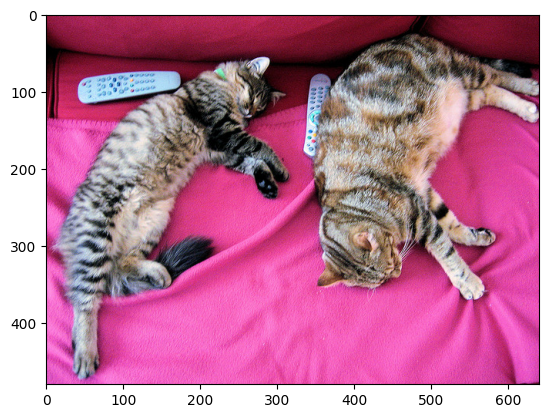

In [ ]:
# model predicts one of the 1000 ImageNet classes
predicted_label = int(tf.math.argmax(logits, axis=-1))
print(model.config.id2label[predicted_label])
plt.imshow(image)

In [ ]:
len(output.attentions)

12

In [ ]:
attention_maps = output.attentions

In [ ]:
attention_maps[4].shape

torch.Size([1, 12, 197, 197])

Head attention:

![texto del vínculo](https://www.researchgate.net/publication/369414041/figure/fig5/AS:11431281128957038@1679457024913/DINO-samples-Visualization-of-the-attention-matrix-of-ViT-heads-trained-with-DINO-The.png)

### Actividad 1

Visualice el mapa de atención de las últimas 2 capas de autoatención y proyectelo sobre la imágen original.

Hint: Los mapas de atención multicabezales se promedian en uno solo

Hint2: Rescale el mapa de atención

In [ ]:
# Programe aqui

## Swin Segmentation

In [ ]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
from huggingface_hub import hf_hub_download

image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-large")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-large", output_attentions=True)

filepath = hf_hub_download(
    repo_id="hf-internal-testing/fixtures_ade20k", filename="ADE_val_00000001.jpg", repo_type="dataset"
)
image = Image.open(filepath).convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits  # shape (batch_size, num_labels, height, width)

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/940M [00:00<?, ?B/s]

ADE_val_00000001.jpg:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

In [ ]:
import torch

upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [ ]:
def ade_palette():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

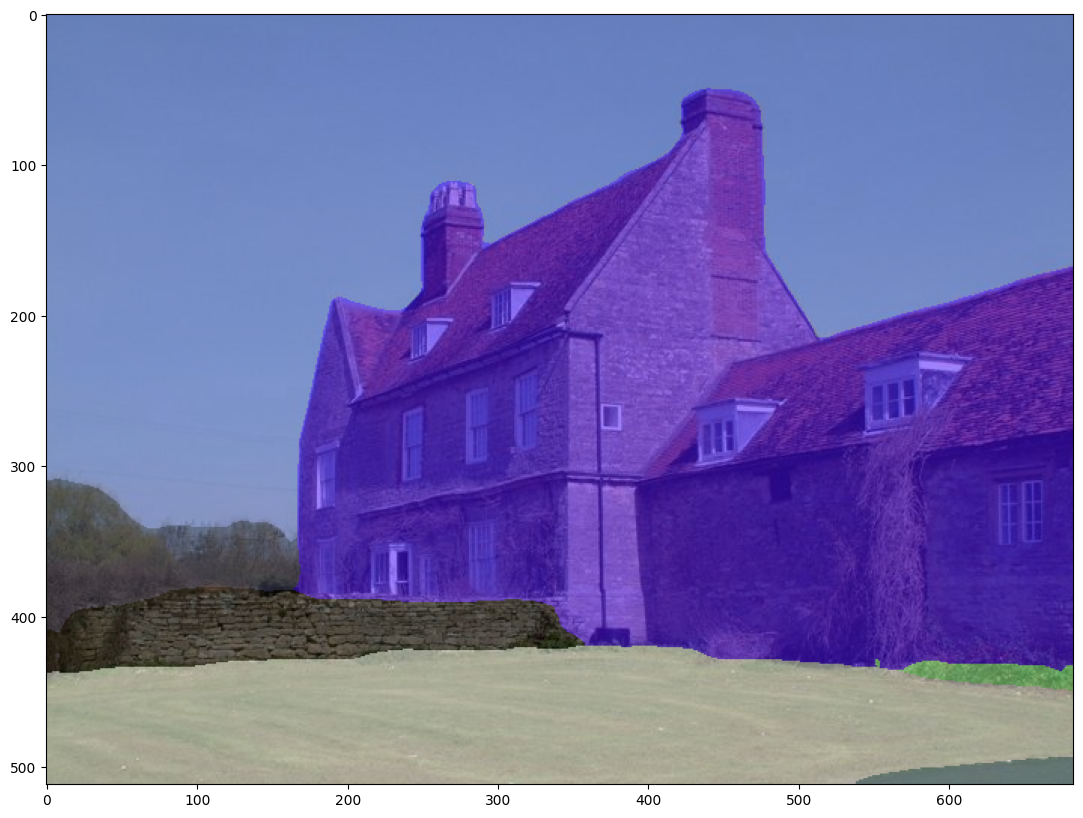

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
model
#model.summary()

UperNetForSemanticSegmentation(
  (backbone): SwinBackbone(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): Swin

In [ ]:
print(outputs.attentions[0].shape)
print(outputs.attentions[1].shape)
print(outputs.attentions[2].shape)
print(outputs.attentions[3].shape)

torch.Size([121, 6, 144, 144])
torch.Size([36, 12, 144, 144])
torch.Size([9, 24, 144, 144])
torch.Size([4, 48, 144, 144])


In [ ]:
# Get batch size and number of heads
batch_size, num_heads, seq_length, _ = outputs.attentions[3].shape


# Reshape and combine attention maps for each batch
reshaped_attention_maps = outputs.attentions[3].squeeze().detach().cpu().numpy()
combined_attention_maps = np.mean(reshaped_attention_maps, axis=0)
combined_attention_maps = np.mean(combined_attention_maps, axis=0)

In [ ]:
res = combined_attention_maps.reshape([12*12, 12, 12])
res = np.mean(res, axis=0)

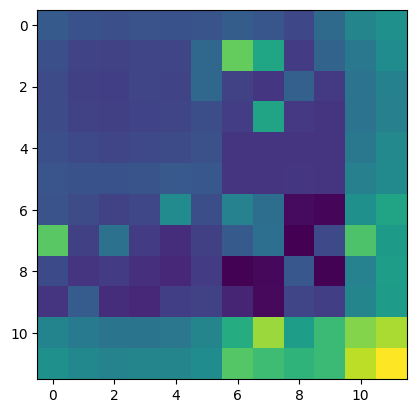

In [ ]:
plt.imshow(res)

In [ ]:
import cv2
res = cv2.resize(res, dsize=(683, 512), interpolation=cv2.INTER_CUBIC)

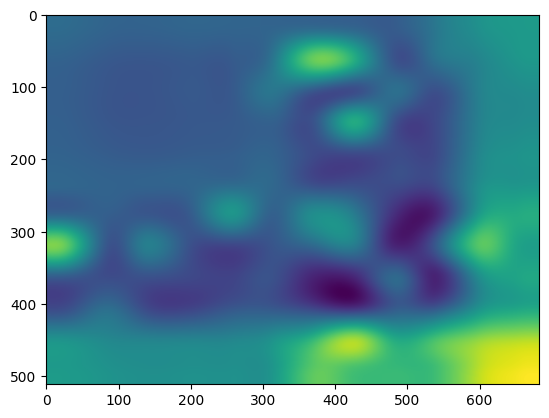

In [ ]:
plt.imshow(res)

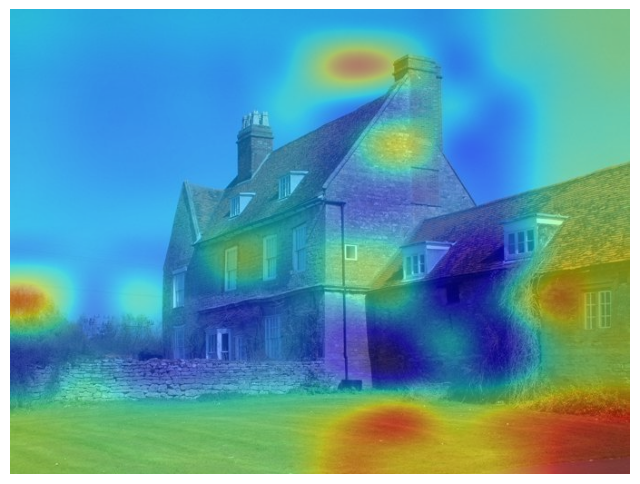

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)
ax.imshow(res, cmap="jet", alpha=0.5, interpolation="bilinear")

plt.axis("off")
plt.show()